In [1]:
from datetime import datetime
import numpy as np
import polars as pl
from pathlib import Path
from polars import col, lit
import pandas as pd
import time
from pandas.io.common import get_handle

In [2]:
pl.__version__

'0.14.28'

In [3]:
pd.__version__

'1.5.2'

In [4]:
# Download a huge csv as a test. Takes a while and only needed once...
big_csv = Path("./big.csv")
csv_url = "http://sdm.lbl.gov/fastbit/data/star2002-full.csv.gz"

# Obtains the path for big_csv, this file of moderate size 15,857,624 rows and 16 columns
if not big_csv.exists():
    with get_handle(csv_url, compression="gzip", mode="r") as fh_in, open(big_csv, "bw") as fh_out:
        fh_out.write(fh_in.handle.buffer.read())

# Load Data 

In [5]:
s = time.time()
df_pandas = pd.read_csv(big_csv)
e = time.time()
pd_time = e - s
print("Pandas Loading Time = {}".format(pd_time))

Pandas Loading Time = 36.4776177406311


In [6]:
s = time.time()
df_pypolars = pl.read_csv(big_csv)
e = time.time()
pl_time = e - s 
print("PyPolars Loading Time = {}".format(pl_time))

PyPolars Loading Time = 7.07993221282959


# Eager 

In terms of eager eval we are performing a filter and selection while tracking time 

In [7]:
# Operation we are performing:
# filter for column 1 == 1 and then selecting col 9 vals

s = time.time()
edf_pl = pl.read_csv(str(big_csv), has_header=False)
print(edf_pl.filter(col("column_1") == 1).select(["column_9"]).head())
e = time.time()
pl_time = e - s 
print("PyPolars Time = {}".format(pl_time))

shape: (5, 1)
┌──────────┐
│ column_9 │
│ ---      │
│ i64      │
╞══════════╡
│ 654      │
├╌╌╌╌╌╌╌╌╌╌┤
│ 61       │
├╌╌╌╌╌╌╌╌╌╌┤
│ 7        │
├╌╌╌╌╌╌╌╌╌╌┤
│ 27       │
├╌╌╌╌╌╌╌╌╌╌┤
│ 1        │
└──────────┘
PyPolars Time = 10.59482717514038


In [8]:
df_pandas = pd.read_csv(big_csv)
s = time.time()
edf_pd = pd.read_csv((big_csv), header=None).reset_index()
print(edf_pd[edf_pd[0] == 1][[8]].head())
e = time.time()
pd_time = e - s 
print("Pandas Time = {}".format(pd_time))

      8
0   654
1    61
2     7
6    27
10    1
Pandas Time = 51.340972900390625


Two comments: 
Polars is cleaner - uses col to refer to the column of the current dataframe is much cleaner
It's not possible to switch later from eager to lazy execution

# Lazy

Just switching read_csv to scan_csv is all it needs to go from eager to lazy in this example. collect or fetch is then used to trigger the execution.

The key advantage of Polars over Pandas is its support for lazy evaluation. Lazy evaluation allows the library to analyze and optimize all of the queries before it starts executing any of the queries. By doing so, the library can save a lot of time by reducing the amount of work processing redundant operations.

The scan_csv() method delays execution until the collect() method is called. It analyzes all the queries right up until the collect() method and tries to optimize the operation. The following code snippet shows how to use the scan_csv() method together with the collect() method:

In [20]:
ldf = (pl.scan_csv(str(big_csv), has_header=False)
        .filter(col("column_1") == 1)
        .select(["column_9"]))

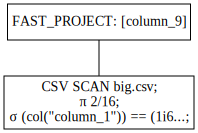

In [21]:
ldf.show_graph(optimized=True)

In [32]:
ldf.select(["column_9"]).collect().head()

column_9
i64
654
61
7
27
1


Pandas style fails in lazy mode:

In [26]:
ldf_pd = pl.scan_csv(str(big_csv), has_header=False)
ldf_pd[ldf_pd[0] == 1][[8]].head()

TypeError: 'LazyFrame' object is not subscriptable (aside from slicing). Use 'select()' or 'filter()' instead.

# Indexing

Slicing and indexing in Polars works with the help of the subscript syntax similar to Numpy, i.e. df[1] or df[1, 2]. Some simple rules apply:
<ul>
<li>indexing by a single dimension</li>
<ul>
<li>returns one or several rows if indexed by an integer, e.g. df[42], df[42:],</li>
<li>returns one or several columns if index by a string, e.g. , df["my_col"], df[["col1", "col2]],
</ul>
</ul>
<ul>    
<li>indexing by two dimensions</li>

<ul>
<li>returns the row(s) indexed by an integer in the first dimension and the column(s) indexed by integer or string in the second dimension, e.g. df[69, 42] or df[69, "col_42"]</li>
</ul>
    
In case of integers also slices, e.g. 1:, are possible.

In [9]:
edf = edf_pl

In [10]:
edf['column_2'].head()

shape: (10,)
Series: 'column_2' [i64]
[
	1613423
	1613423
	1613423
	1613423
	1613423
	1613423
	1613423
	1613423
	1613423
	1613423
]

In [11]:
edf_pl[[1]]

column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10,column_11,column_12,column_13,column_14,column_15,column_16
i64,i64,i64,f64,i64,i64,i64,i64,i64,i64,f64,f64,i64,f64,f64,f64
1,1613423,808,2.0011e7,1613424,886,0,0,61,371,2.0011e7,23.326479,2288071,-0.24733,0.455916,57.810596


In [12]:
edf[1, 3] # index by (row, column)

20011015.222604

In [13]:
edf[1, "column_4"] # or as string

20011015.222604

In [14]:
edf[1, [2, 3]]  # index by (row, column) but returns data frame

column_3,column_4
i64,f64
808,2.0011e7


In [15]:
edf[1:4, "column_4":] # slice by row and column's name

column_4,column_5,column_6,column_7,column_8,column_9,column_10,column_11,column_12,column_13,column_14,column_15,column_16
f64,i64,i64,i64,i64,i64,i64,f64,f64,i64,f64,f64,f64
2.0011e7,1613424,886,0,0,61,371,2.0011e7,23.326479,2288071,-0.24733,0.455916,57.810596
2.0011e7,1613424,638,0,0,7,121,2.0011e7,2.4442992,2288071,-0.390961,0.589534,167.75714
2.0011e7,1613424,4259,0,0,1024,1302,2.0011e7,9.5218678,2288071,-0.290154,0.446027,8.6443624


Since in Pandas there is an explicit index that can be any type, not just integer and columns that can have any immutable datatype, it has to workaround several ambiguities with special functions like iloc, loc, at, iat, etc.

In [16]:
pdf = edf.to_pandas()

In [17]:
pdf.iloc[1, 3]

20011015.222604

In [18]:
# when mixing indexing by integer and by string it gets less comprehensible in Pandas
pdf["column_4"].iloc[1] 

20011015.222604

In [19]:
pdf.iloc[1, [2, 3]]

column_3    8.080000e+02
column_4    2.001102e+07
Name: 1, dtype: float64

In [24]:
pdf.loc[1:3, "column_4":]

,column_4,column_5,column_6,column_7,column_8,column_9,column_10,column_11,column_12,column_13,column_14,column_15,column_16
1,2.001102e+07,1613424,886,0,0,61,371,2.001120e+07,23.326479,2288071,-0.247330,0.455916,57.810596
2,2.001102e+07,1613424,638,0,0,7,121,2.001120e+07,2.444299,2288071,-0.390961,0.589534,167.757140
3,2.001102e+07,1613424,4259,0,0,1024,1302,2.001120e+07,9.521868,2288071,-0.290154,0.446027,8.644362


# Missing Values

In [60]:
left_df = pl.DataFrame({"a": [1, 2, 3], "b": [None, "b", "c"]})
right_df = pl.DataFrame({"a": [1, 2], "c": [42, 69]})

df = left_df.join(right_df, on="a", how="left")
df

a,b,c
i64,str,i64
1,null,42
2,"""b""",69
3,"""c""",null


Note that the last element of the c column is null, not NaN as in Pandas, and the datatype is still int and not automatically converted to float as in Pandas.

Pandas does something pretty scary here \
Note that "c"-column has type int:

In [35]:
left_pdf = left_df.to_pandas()
right_pdf = right_df.to_pandas()
right_pdf.dtypes

a    int64
c    int64
dtype: object

In [56]:
pdf = pd.merge(left_pdf, right_pdf, on="a", how="left")
pdf

,a,b,c
0,1,None,42.0
1,2,b,69.0
2,3,c,NaN


# Column Expressions

In [37]:
df = pl.DataFrame(
    {
        "nrs": [1, 2, 3, None, 5],
        "names": ["foo", "ham", "spam", "egg", None],
        "random": np.random.rand(5),
        "groups": ["A", "A", "B", "C", "B"],
    }
)
df

nrs,names,random,groups
i64,str,f64,str
1,"""foo""",0.330487,"""A"""
2,"""ham""",0.538228,"""A"""
3,"""spam""",0.030938,"""B"""
null,"""egg""",0.545556,"""C"""
5,null,0.29049,"""B"""


In [38]:
# To select the columns when randome is greater than 0.5 then 0 otherwise random * nrs
# All expressions in Polars are parallel by design
df.select(
    [
        (pl.sum("nrs") * pl.when(col("random") > 0.5)
                           .then(0)
                           .otherwise(col("random"))
        ).alias("result")
    ]
)

result
f64
3.635353
0.0
0.340313
0.0
3.195389


In [39]:
# SQL-like when/then/otherwise statements are not possible in Pandas, thus we have to use np.where
pdf = df.to_pandas()
pd.Series(
    np.where(pdf["random"] > 0.5, 0, pdf["random"] * pdf["nrs"].sum()), name="result"
).to_frame()

,result
0,3.635353
1,0.000000
2,0.340313
3,0.000000
4,3.195389


# Groupby

In [ ]:
df = pl.read_csv("https://theunitedstates.io/congress-legislators/legislators-current.csv")
pdf = df.to_pandas()

In [ ]:
pdf

Note how easily we can deal with lists of strings by aggregating over gender using list().

In Pandas the same operation feels more like string hacking and renaming happens as a separate step having unnecessary repetitions of the column names. Everything is of course eagerly evaluated.

In [ ]:
(df.lazy()  # allows for working only on a subset using limit
   .groupby("first_name")
   .agg(
       [
           col("party").count().alias("n_party"),  # renaming an aggregated column is a bliss
           col("gender").list(),
           col("last_name").first(),
       ]
   )
   .sort("n_party", reverse=True)
   .limit(5)
   .collect()
)

In [ ]:
(pdf.groupby("first_name")
    .agg({"party": "count", 
          "gender": lambda grp: grp.to_list(), 
          "last_name": "first"})
    .rename(columns={"party": "n_party", 
                     "gender": "gender_agg_list", 
                     "last_name": "last_name_first"})
    .sort_values(by="n_party", ascending=False)
    .reset_index()
    .head(5))